In [3]:
from IPython.display import Image

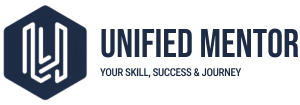

In [4]:
display(Image(filename="C:/Users/Asus/Desktop/unified_logo.png"))

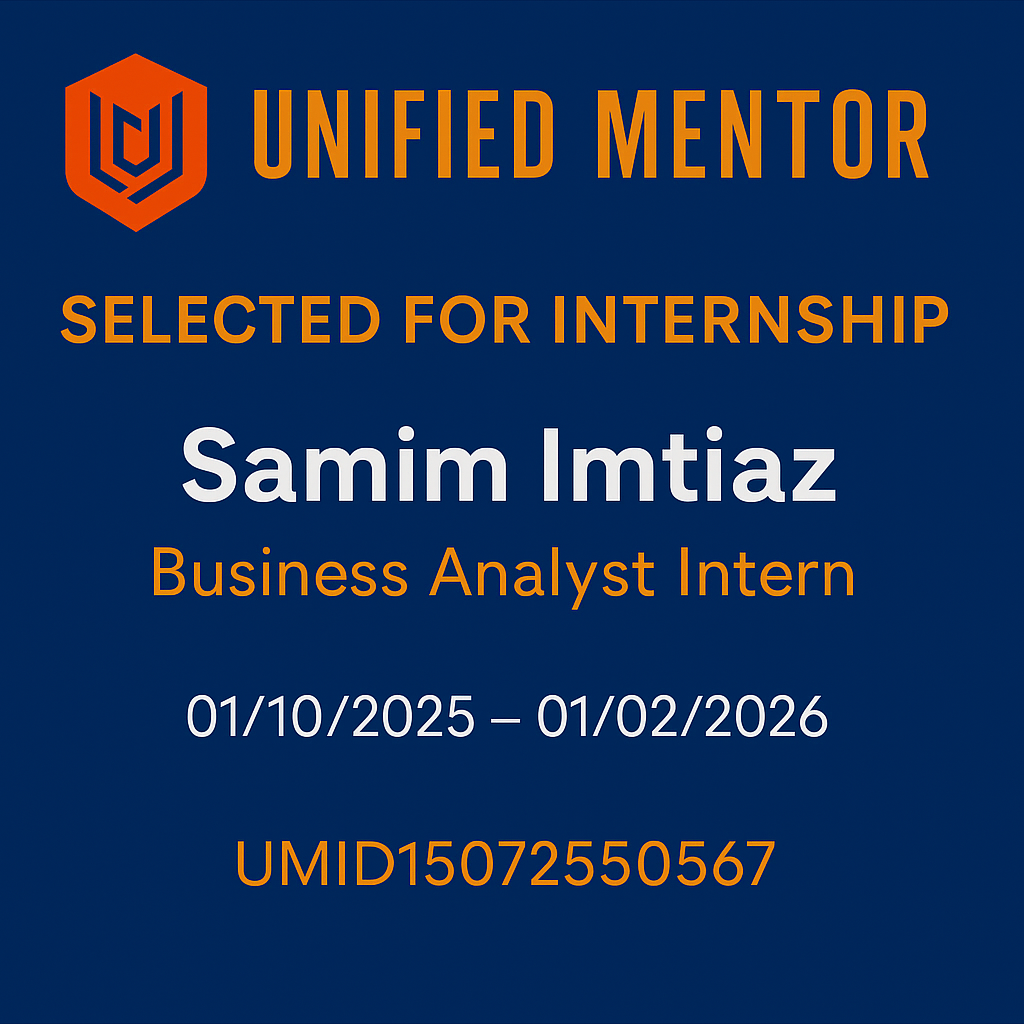

In [5]:
display(Image(filename="C:/Users/Asus/Desktop/unified.png", width=300, height=50))

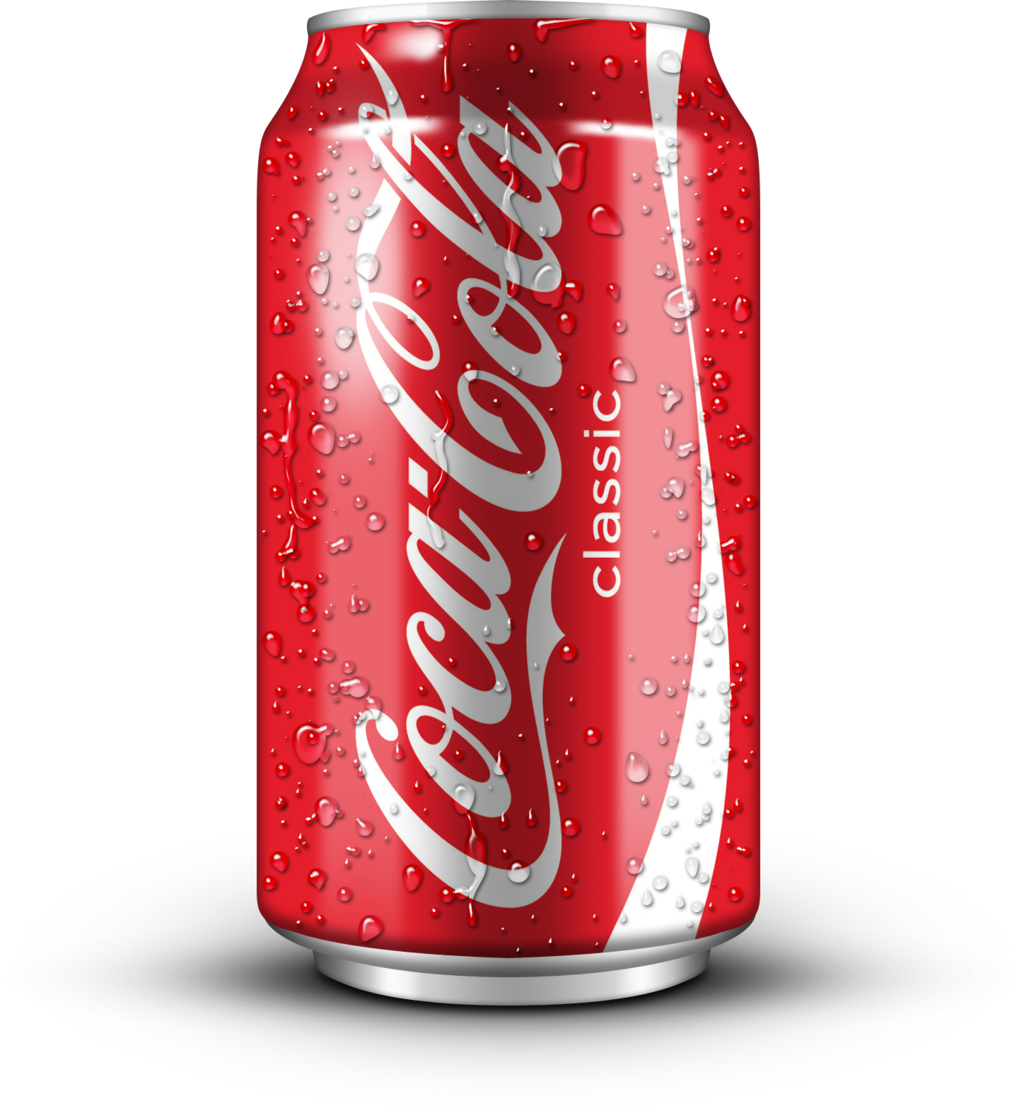

In [6]:
display(Image(filename="C:/Users/Asus/Desktop/COKE.png", width=300, height=50))

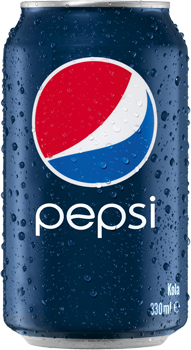

In [7]:
display(Image(filename="C:/Users/Asus/Desktop/PEPSI.png", width=150, height=25))

# **📘Objective**

**Coke & Pepsi Stocks Analysis 📊**

**📕Import Necessary Library🗂️**

In [8]:
!pip install yfinance

In [9]:
import yfinance as yf
import pandas as pd

In [10]:
# coke & pepsi Stocks
tickers = ['KO', 'PEP']

# Download all at once
data = yf.download(tickers, start="2020-01-01", end="2025-11-01", auto_adjust=False, progress=False)

# Fix multi-level columns
data.columns.names = ['Attribute', 'Stock']

# Convert wide → long
df = data.stack(level='Stock').reset_index()

# Remove 'Adj Close' safely if missing
cols_to_keep = [c for c in ['Date', 'Stock', 'Open', 'High', 'Low', 'Close', 'Volume'] if c in df.columns]
df = df[cols_to_keep]

# Ensure proper datetime and sorting
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values(['Stock', 'Date']).reset_index(drop=True)

# Save clean file
df.to_csv("KOPEP_Stocks_Clean.csv", index=False)
print("✅ Saved KOPEP_Stocks_Clean.csv —", len(df), "rows")
print(df.head())

✅ Saved KOPEP_Stocks_Clean.csv — 2934 rows
Attribute       Date Stock       Open       High        Low      Close  \
0         2020-01-02    KO  55.320000  55.430000  54.759998  54.990002   
1         2020-01-03    KO  54.320000  54.990002  54.090000  54.689999   
2         2020-01-06    KO  54.650002  54.910000  54.520000  54.669998   
3         2020-01-07    KO  54.450001  54.599998  54.150002  54.250000   
4         2020-01-08    KO  54.270000  54.639999  54.150002  54.349998   

Attribute    Volume  
0          11867700  
1          11354500  
2          14698300  
3           9973900  
4          10676000  


In [11]:
df.to_csv(r"C:\Users\Asus\Desktop\KOPEP_Stocks_Clean.csv", index=False)

print("✅ File saved to Desktop successfully!")
print("Rows:", len(df))
print(df.head())

✅ File saved to Desktop successfully!
Rows: 2934
Attribute       Date Stock       Open       High        Low      Close  \
0         2020-01-02    KO  55.320000  55.430000  54.759998  54.990002   
1         2020-01-03    KO  54.320000  54.990002  54.090000  54.689999   
2         2020-01-06    KO  54.650002  54.910000  54.520000  54.669998   
3         2020-01-07    KO  54.450001  54.599998  54.150002  54.250000   
4         2020-01-08    KO  54.270000  54.639999  54.150002  54.349998   

Attribute    Volume  
0          11867700  
1          11354500  
2          14698300  
3           9973900  
4          10676000  


In [12]:
df.head()

Attribute,Date,Stock,Open,High,Low,Close,Volume
0,2020-01-02,KO,55.320000,55.430000,54.759998,54.990002,11867700
1,2020-01-03,KO,54.320000,54.990002,54.090000,54.689999,11354500
2,2020-01-06,KO,54.650002,54.910000,54.520000,54.669998,14698300
3,2020-01-07,KO,54.450001,54.599998,54.150002,54.250000,9973900
4,2020-01-08,KO,54.270000,54.639999,54.150002,54.349998,10676000


**Proper types & order**

In [13]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values(['Stock','Date']).reset_index(drop=True)


g = df.groupby('Stock', group_keys=False)

**Core OHLC enrichments**

In [14]:
df['Prev Close'] = g['Close'].shift(1)
df['Last'] = df['Close']                                  # daily last price ≈ close
df['VWAP'] = (df['High'] + df['Low'] + df['Close']) / 3   # proxy (no intraday volume)
df['Turnover'] = df['Close'] * df['Volume']               # value traded (currency*shares)
df['Deliverable Volume'] = df['Volume']                   # proxy (Yahoo lacks delivery)

**Daily metrics**

In [15]:
df['Daily_Return_%'] = (df['Close'] / df['Prev Close'] - 1) * 100
df['Volatility'] = df['High'] - df['Low']
df['7D_MA_Close']  = g['Close'].transform(lambda s: s.rolling(7,  min_periods=7).mean())
df['30D_MA_Close'] = g['Close'].transform(lambda s: s.rolling(30, min_periods=30).mean())

**Rolling-period returns (trading-day approximations)**

In [16]:
def pct_ret(s, periods):
    return (s / s.shift(periods) - 1) * 100

df['1DAY'] = g['Close'].apply(lambda s: pct_ret(s, 1))
df['1WK']  = g['Close'].apply(lambda s: pct_ret(s, 5))
df['1M']   = g['Close'].apply(lambda s: pct_ret(s, 21))
df['1Y']   = g['Close'].apply(lambda s: pct_ret(s, 252))
df['5Y']   = g['Close'].apply(lambda s: pct_ret(s, 1260))
df['52WK'] = df['1Y']  

**YTD return**

In [17]:
df['Year'] = df['Date'].dt.year
first_close_y = df.groupby(['Stock','Year'])['Close'].transform('first')
df['YTD'] = (df['Close'] / first_close_y - 1) * 100

**Round presentation columns**

In [18]:
round_cols = ['Daily_Return_%','1DAY','1WK','1M','1Y','5Y','52WK','YTD','VWAP','Volatility']
df[round_cols] = df[round_cols].round(4)

**Reorder columns**

In [19]:
cols = ['Date','Stock','Open','High','Low','Close','Prev Close','Last','VWAP',
        'Volume','Turnover','Deliverable Volume','Volatility',
        'Daily_Return_%','7D_MA_Close','30D_MA_Close',
        '1DAY','1WK','1M','YTD','52WK','1Y','5Y']
df = df[cols]

In [20]:
df.head()

Attribute,Date,Stock,Open,High,Low,Close,Prev Close,Last,VWAP,Volume,...,Daily_Return_%,7D_MA_Close,30D_MA_Close,1DAY,1WK,1M,YTD,52WK,1Y,5Y
0,2020-01-02,KO,55.320000,55.430000,54.759998,54.990002,NaN,54.990002,55.0600,11867700,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN
1,2020-01-03,KO,54.320000,54.990002,54.090000,54.689999,54.990002,54.689999,54.5900,11354500,...,-0.5456,NaN,NaN,-0.5456,NaN,NaN,-0.5456,NaN,NaN,NaN
2,2020-01-06,KO,54.650002,54.910000,54.520000,54.669998,54.689999,54.669998,54.7000,14698300,...,-0.0366,NaN,NaN,-0.0366,NaN,NaN,-0.5819,NaN,NaN,NaN
3,2020-01-07,KO,54.450001,54.599998,54.150002,54.250000,54.669998,54.250000,54.3333,9973900,...,-0.7682,NaN,NaN,-0.7682,NaN,NaN,-1.3457,NaN,NaN,NaN
4,2020-01-08,KO,54.270000,54.639999,54.150002,54.349998,54.250000,54.349998,54.3800,10676000,...,0.1843,NaN,NaN,0.1843,NaN,NaN,-1.1639,NaN,NaN,NaN


In [21]:
tickers = ["KO", "PEP"]
data_fin = []

for t in tickers:
    ticker = yf.Ticker(t)
    fin = ticker.financials
    fin = fin.reset_index().melt(id_vars=['index'], var_name='Year', value_name='Value')
    fin['Stock'] = t
    data_fin.append(fin)

kopep_fin = pd.concat(data_fin)
kopep_fin.rename(columns={'index':'Metric'}, inplace=True)
kopep_fin.to_csv("KOPEP_fin.csv", index=False)

In [22]:
kopep_fin.head()

,Metric,Year,Value,Stock
0,Tax Effect Of Unusual Items,2024-12-31,-3.693960e+08,KO
1,Tax Rate For Calcs,2024-12-31,1.860000e-01,KO
2,Normalized EBITDA,2024-12-31,1.780300e+10,KO
3,Total Unusual Items,2024-12-31,-1.986000e+09,KO
4,Total Unusual Items Excluding Goodwill,2024-12-31,-1.986000e+09,KO


In [23]:
kopep_fin.tail()

,Metric,Year,Value,Stock
215,Selling General And Administration,2020-12-31,NaN,PEP
216,Gross Profit,2020-12-31,NaN,PEP
217,Cost Of Revenue,2020-12-31,NaN,PEP
218,Total Revenue,2020-12-31,NaN,PEP
219,Operating Revenue,2020-12-31,NaN,PEP


In [24]:
len(kopep_fin)

515

In [25]:
kopep_fin['Metric'].unique()

array(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA', 'Total Unusual Items',
       'Total Unusual Items Excluding Goodwill',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT', 'Net Interest Income', 'Interest Expense',
       'Interest Income', 'Normalized Income',
       'Net Income From Continuing And Discontinued Operation',
       'Total Expenses', 'Total Operating Income As Reported',
       'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS',
       'Basic EPS', 'Diluted NI Availto Com Stockholders',
       'Net Income Common Stockholders', 'Net Income',
       'Minority Interests',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Tax Provision',
       'Pretax Income', 'Other Income Expense',
       'Other Non Operating Income Expenses', 'Special Income Charges',
       'Gain O

In [25]:
df.to_csv(r"C:\Users\Asus\Desktop\KOPEP_Fin_Clean.csv", index=False)

print("✅ File saved to Desktop successfully!")
print("Rows:", len(df))
print(df.head())

✅ File saved to Desktop successfully!
Rows: 2934
Attribute       Date Stock       Open       High        Low      Close  \
0         2020-01-02    KO  55.320000  55.430000  54.759998  54.990002   
1         2020-01-03    KO  54.320000  54.990002  54.090000  54.689999   
2         2020-01-06    KO  54.650002  54.910000  54.520000  54.669998   
3         2020-01-07    KO  54.450001  54.599998  54.150002  54.250000   
4         2020-01-08    KO  54.270000  54.639999  54.150002  54.349998   

Attribute  Prev Close       Last     VWAP    Volume  ...  Daily_Return_%  \
0                 NaN  54.990002  55.0600  11867700  ...             NaN   
1           54.990002  54.689999  54.5900  11354500  ...         -0.5456   
2           54.689999  54.669998  54.7000  14698300  ...         -0.0366   
3           54.669998  54.250000  54.3333   9973900  ...         -0.7682   
4           54.250000  54.349998  54.3800  10676000  ...          0.1843   

Attribute  7D_MA_Close  30D_MA_Close    1DAY  1WK

In [26]:
data_reco = []

for t in tickers:
    ticker = yf.Ticker(t)
    reco = ticker.recommendations
    reco['Stock'] = t
    data_reco.append(reco)

kopep_reco = pd.concat(data_reco)
kopep_reco.reset_index(inplace=True)
kopep_reco.rename(columns={'index':'Date'}, inplace=True)
kopep_reco.to_csv("KOPEP_reco.csv", index=False)

In [27]:
kopep_reco.head()

,Date,period,strongBuy,buy,hold,sell,strongSell,Stock
0,0,0m,8,13,3,0,0,KO
1,1,-1m,8,13,3,0,0,KO
2,2,-2m,8,14,3,0,0,KO
3,3,-3m,7,14,4,0,0,KO
4,0,0m,2,4,16,2,0,PEP


In [28]:
df.to_csv(r"C:\Users\Asus\Desktop\KOPEP_Reco_Clean.csv", index=False)

print("✅ File saved to Desktop successfully!")
print("Rows:", len(df))
print(df.head())

✅ File saved to Desktop successfully!
Rows: 2934
Attribute       Date Stock       Open       High        Low      Close  \
0         2020-01-02    KO  55.320000  55.430000  54.759998  54.990002   
1         2020-01-03    KO  54.320000  54.990002  54.090000  54.689999   
2         2020-01-06    KO  54.650002  54.910000  54.520000  54.669998   
3         2020-01-07    KO  54.450001  54.599998  54.150002  54.250000   
4         2020-01-08    KO  54.270000  54.639999  54.150002  54.349998   

Attribute  Prev Close       Last     VWAP    Volume  ...  Daily_Return_%  \
0                 NaN  54.990002  55.0600  11867700  ...             NaN   
1           54.990002  54.689999  54.5900  11354500  ...         -0.5456   
2           54.689999  54.669998  54.7000  14698300  ...         -0.0366   
3           54.669998  54.250000  54.3333   9973900  ...         -0.7682   
4           54.250000  54.349998  54.3800  10676000  ...          0.1843   

Attribute  7D_MA_Close  30D_MA_Close    1DAY  1WK

In [29]:
len(kopep_reco)

8

In [30]:
data_bal = []

for t in tickers:
    ticker = yf.Ticker(t)
    bal = ticker.balance_sheet
    bal = bal.reset_index().melt(id_vars=['index'], var_name='Year', value_name='Value')
    bal['Stock'] = t
    data_bal.append(bal)

kopep_balance = pd.concat(data_bal)
kopep_balance.rename(columns={'index':'Metric'}, inplace=True)
kopep_balance.to_csv("KOPEP_balance.csv", index=False)

In [31]:
kopep_balance.head()

,Metric,Year,Value,Stock
0,Treasury Shares Number,2024-12-31,2.738000e+09,KO
1,Ordinary Shares Number,2024-12-31,4.302000e+09,KO
2,Share Issued,2024-12-31,7.040000e+09,KO
3,Net Debt,2024-12-31,3.369400e+10,KO
4,Total Debt,2024-12-31,4.452200e+10,KO


In [32]:
len(kopep_balance)

790

In [33]:
df.to_csv(r"C:\Users\Asus\Desktop\KOPEP_Blance_Clean.csv", index=False)

print("✅ File saved to Desktop successfully!")
print("Rows:", len(df))
print(df.head())

✅ File saved to Desktop successfully!
Rows: 2934
Attribute       Date Stock       Open       High        Low      Close  \
0         2020-01-02    KO  55.320000  55.430000  54.759998  54.990002   
1         2020-01-03    KO  54.320000  54.990002  54.090000  54.689999   
2         2020-01-06    KO  54.650002  54.910000  54.520000  54.669998   
3         2020-01-07    KO  54.450001  54.599998  54.150002  54.250000   
4         2020-01-08    KO  54.270000  54.639999  54.150002  54.349998   

Attribute  Prev Close       Last     VWAP    Volume  ...  Daily_Return_%  \
0                 NaN  54.990002  55.0600  11867700  ...             NaN   
1           54.990002  54.689999  54.5900  11354500  ...         -0.5456   
2           54.689999  54.669998  54.7000  14698300  ...         -0.0366   
3           54.669998  54.250000  54.3333   9973900  ...         -0.7682   
4           54.250000  54.349998  54.3800  10676000  ...          0.1843   

Attribute  7D_MA_Close  30D_MA_Close    1DAY  1WK

In [34]:
import numpy as np
import pandas as pd

np.random.seed(42)  # reproducible results

# --- Region definitions and totals (as agreed) ---
cc_regions = {
    "North America": {"total": 18.9, "countries": ["USA","Canada","Mexico","Ukraine","Rusia Republic"]},
    "Latin America": {"total": 6.4,  "countries": ["Libya","Egypt","Sudan","Ethiopia","Nigeria"]},
    "EMEA":          {"total": 10.9, "countries": ["Germany","UK","India","Poland","UAE"]},
    "Asia Pacific":  {"total": 5.5,  "countries": ["China","Japan","Kazakhstan","Chad","Sudan"]}
}

# Pepsi totals (overall and region breakdown)
pep_total = 91.854
pep_regions = {
    "North America": {"total": 55.43, "countries": ["USA","Canada","Mexico","Niger","Dominican Republic"]},
    "Latin America": {"total": 7.12,  "countries": ["Brazil","Mali","Chile","Iran","Camerun"]},
    "EMEA":          {"total": pep_total - (55.43 + 7.12 + 2.71), "countries": ["Germany","UK","India","Angola","SothSudan"]},
    "Asia Pacific":  {"total": 2.71,  "countries": ["China","Japan","Australia","Turkey","Indonesia"]}
}

def random_split_region(region_total, n=5, low_pct=0.08, high_pct=0.16):
    """
    Generate n random fractions between low_pct and high_pct (as fraction of region total),
    then normalize them so their sum equals region_total exactly.
    Returns a list of per-country revenues.
    """
    # Generate random factors in [low_pct, high_pct]
    factors = np.random.uniform(low_pct, high_pct, size=n)
    # Normalize factors so the sum of resulting revenues equals region_total
    normalized = factors / factors.sum()
    revenues = normalized * region_total
    return revenues

rows = []

# Build Coca-Cola rows
for region_name, info in cc_regions.items():
    revs = random_split_region(info["total"], n=len(info["countries"]), low_pct=0.08, high_pct=0.16)
    for country, r in zip(info["countries"], revs):
        rows.append({
            "Company": "Coca-Cola",
            "Country": country,
            "Region": region_name,
            "Revenue_USD_billion": round(float(r), 3)
        })

# Build PepsiCo rows
for region_name, info in pep_regions.items():
    revs = random_split_region(info["total"], n=len(info["countries"]), low_pct=0.08, high_pct=0.16)
    for country, r in zip(info["countries"], revs):
        rows.append({
            "Company": "PepsiCo",
            "Country": country,
            "Region": region_name,
            "Revenue_USD_billion": round(float(r), 3)
        })

df = pd.DataFrame(rows)

# Add percent of company total column
df["Company_Total_USD_billion"] = df.groupby("Company")["Revenue_USD_billion"].transform("sum")
df["%_of_Company_Total"] = (df["Revenue_USD_billion"] / df["Company_Total_USD_billion"] * 100).round(2).astype(str) + "%"

# Save to Desktop (change path if your username differs)
out_path = r"C:\Users\Asus\Desktop\KOPEP_Geo_RandomSplit.csv"
df.to_csv(out_path, index=False, float_format="%.3f")

print("✅ Saved:", out_path)
print("Rows:", len(df))
print(df.groupby(["Company","Region"])["Revenue_USD_billion"].sum().round(3))
df.head(10)


✅ Saved: C:\Users\Asus\Desktop\KOPEP_Geo_RandomSplit.csv
Rows: 40
Company    Region       
Coca-Cola  Asia Pacific      5.499
           EMEA             10.900
           Latin America     6.399
           North America    18.901
PepsiCo    Asia Pacific      2.710
           EMEA             26.594
           Latin America     7.120
           North America    55.430
Name: Revenue_USD_billion, dtype: float64


,Company,Country,Region,Revenue_USD_billion,Company_Total_USD_billion,%_of_Company_Total
0,Coca-Cola,USA,North America,3.326,41.699,7.98%
1,Coca-Cola,Canada,North America,4.720,41.699,11.32%
2,Coca-Cola,Mexico,North America,4.190,41.699,10.05%
3,Coca-Cola,Ukraine,North America,3.868,41.699,9.28%
4,Coca-Cola,Rusia Republic,North America,2.797,41.699,6.71%
5,Coca-Cola,Libya,Latin America,1.001,41.699,2.4%
6,Coca-Cola,Egypt,Latin America,0.916,41.699,2.2%
7,Coca-Cola,Sudan,Latin America,1.616,41.699,3.88%
8,Coca-Cola,Ethiopia,Latin America,1.387,41.699,3.33%
9,Coca-Cola,Nigeria,Latin America,1.479,41.699,3.55%


In [36]:
import pandas as pd
import os

base_path = r"C:\Users\Asus\Desktop"   
files = {
    "stocks": base_path + r"\KOPEP_Stocks_Clean.csv",
    "fin":    base_path + r"\KOPEP_Fin_Clean.csv",
    "bal":    base_path + r"\KOPEP_Blance_Clean.csv",   
    "reco":   base_path + r"\KOPEP_Reco_Clean.csv"
}

# Load files (will raise FileNotFoundError if any missing)
dfs = {k: pd.read_csv(p) for k, p in files.items()}

# Heuristic merge: try best common keys; outer-merge to preserve rows
def best_common_between(df1, df2):
    pref = ["Ticker","Company","Date"]
    common = [c for c in pref if c in df1.columns and c in df2.columns]
    if common:
        return common
    return list(set(df1.columns).intersection(set(df2.columns)))

merged = dfs['stocks'].copy()
for name in ['fin','bal','reco']:
    common = best_common_between(merged, dfs[name])
    if len(common)==0:
        merged = pd.merge(merged.reset_index(), dfs[name].reset_index(), how='outer', left_index=True, right_index=True, suffixes=('','_'+name)).set_index('index', drop=True)
    else:
        merged = pd.merge(merged, dfs[name], how='outer', on=common, suffixes=('','_'+name))

# Coalesce duplicate suffix columns where possible
for col in list(merged.columns):
    if any(col.endswith(s) for s in ['_fin','_bal','_reco']):
        base = col.rsplit('_',1)[0]
        if base in merged.columns:
            merged[base] = merged[base].combine_first(merged[col])
            merged.drop(columns=[col], inplace=True)

out = base_path + r"\KOPEP_Master_Clean.csv"
merged.to_csv(out, index=False)
print("Saved merged file to:", out)
print("Merged shape:", merged.shape)



Saved merged file to: C:\Users\Asus\Desktop\KOPEP_Master_Clean.csv
Merged shape: (23472, 23)


In [26]:
import yfinance as yf
import pandas as pd

tickers = ["KO", "PEP"]

fin_list = []
for t in tickers:
    tk = yf.Ticker(t)
    fin = tk.get_financials().T.reset_index()
    fin["Stock"] = t
    fin_list.append(fin)

all_fin = pd.concat(fin_list)
all_fin.to_csv("finance_ko_pep.csv", index=False)

print("FINANCE FILE READY: finance_ko_pep.csv")


FINANCE FILE READY: finance_ko_pep.csv


In [27]:
import yfinance as yf
import pandas as pd

tickers = ["KO", "PEP"]

fin_list = []
for t in tickers:
    tk = yf.Ticker(t)
    fin = tk.get_financials().T.reset_index()
    fin["Stock"] = t
    fin_list.append(fin)

all_fin = pd.concat(fin_list)

# SAVE DIRECTLY TO DESKTOP
output_path = r"C:\Users\Asus\Desktop\finance_ko_pep.csv"
all_fin.to_csv(output_path, index=False)

print("Saved FINANCE file to:", output_path)


Saved FINANCE file to: C:\Users\Asus\Desktop\finance_ko_pep.csv


In [28]:
import yfinance as yf
import pandas as pd

tickers = ["KO", "PEP"]

bal_list = []
for t in tickers:
    tk = yf.Ticker(t)
    bal = tk.get_balance_sheet().T.reset_index()
    bal["Stock"] = t
    bal_list.append(bal)

all_bal = pd.concat(bal_list)

# SAVE DIRECTLY TO DESKTOP
output_path = r"C:\Users\Asus\Desktop\balance_ko_pep.csv"
all_bal.to_csv(output_path, index=False)

print("Saved BALANCE file to:", output_path)


Saved BALANCE file to: C:\Users\Asus\Desktop\balance_ko_pep.csv


In [29]:
import yfinance as yf
import pandas as pd

tickers = ["KO", "PEP"]

reco_list = []
for t in tickers:
    tk = yf.Ticker(t)
    rec = tk.recommendations
    if rec is not None:
        rec = rec.reset_index()
        rec["Stock"] = t
        reco_list.append(rec)

all_reco = pd.concat(reco_list)
reco_path = r"C:\Users\Asus\Desktop\reco_ko_pep.csv"
all_reco.to_csv(reco_path, index=False)
print("Saved:", reco_path)

print("All files saved successfully!")

Saved: C:\Users\Asus\Desktop\reco_ko_pep.csv
All files saved successfully!


In [4]:
import yfinance as yf
import pandas as pd

tickers = ["KO", "PEP"]

fin_list = []
for t in tickers:
    tk = yf.Ticker(t)
    fin = tk.get_financials(freq="quarterly").T.reset_index()
    fin["Stock"] = t
    fin_list.append(fin)

all_fin = pd.concat(fin_list)
all_fin.to_csv("Finance.csv", index=False)
fin_path = r"C:\Users\Asus\Desktop\Finance.csv"
print("Saved:", fin_path)

print("All files saved successfully!")

print("FINANCE FILE READY: Finance.csv")

Saved: C:\Users\Asus\Desktop\Finance.csv
All files saved successfully!
FINANCE FILE READY: Finance.csv
